In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import operator
from matplotlib.pyplot import subplot
import os
import math
import pandas as pd
os.chdir('20190719_e/')

plt.style.use('seaborn-whitegrid')


In [2]:
waves=np.arange(8000,13000,50)
waves_um=np.arange(8,13,.05)
theta=np.linspace(0,math.pi,19)
def average(arr):
    arr1=arr[0]
    for i in range(1,len(arr)):
        arr1=np.add(arr1,arr[i])
    return(np.divide(arr1,len(arr)))


In [3]:
def file_name(wave_i,angle_i):
    if waves[wave_i]<10000:
        name1='spectral_1_CAM1__0'+str(waves[wave_i])+'nm_angle'+str(angles[angle_i])+'deg.tiff'
        name2='spectral_1_CAM2__0'+str(waves[wave_i])+'nm_angle'+str(angles[angle_i])+'deg.tiff'
    else:
        name1='spectral_1_CAM1__'+str(waves[wave_i])+'nm_angle'+str(angles[angle_i])+'deg.tiff'
        name2='spectral_1_CAM2__'+str(waves[wave_i])+'nm_angle'+str(angles[angle_i])+'deg.tiff'
    return(name1,name2)

In [4]:
angles=np.arange(100,290,10)

In [5]:
theta= np.radians(angles)

In [6]:
def aolpdata_wavelength(i):
    mean1=[];mean2=[];stds1=[];stds2=[]
    for j in range(len(angles)):
        name1,name2 = file_name(i,j)
        image1=Image.open(name1)
        image2=Image.open(name2)
        im1=np.array(image1)[120:125,70:160]
        im2=np.array(image2)[122:127,85:175]
        index1, value1 = max(enumerate(np.flip(average(im1))), key=operator.itemgetter(1))
        index2, value2 = max(enumerate(np.flip(average(im2))), key=operator.itemgetter(1))
        s1=[];s2=[]
        for k in range(len(im1)):
            s1.append(im1[k][index1])
            s2.append(im2[k][index2])
        stds1.append(np.std(s1))
        stds2.append(np.std(s2))
        mean1.append(value1)
        mean2.append(value2)
    return(mean1,mean2,stds1,stds2)

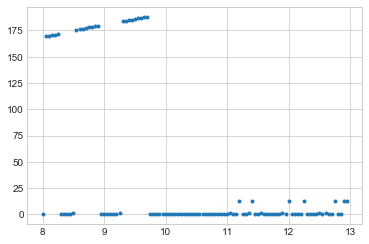

186 9.500000000000021


10.666666666666666

In [49]:
location1=[];location2=[]
for i in range(len(waves)):
    name1,name2 = file_name(i,0)
    image1=Image.open(name1)
    image2=Image.open(name2)
    im1=np.array(image1)[120:125]
    im2=np.array(image2)[122:127]
    index1, value1 = max(enumerate(np.flip(average(im1))), key=operator.itemgetter(1))
    index2, value2 = max(enumerate(np.flip(average(im2))), key=operator.itemgetter(1))
    location1.append(index1)
    location2.append(index2)

plt.plot(waves_um,location1,'.')
#plt.plot(waves_um,location2,'.')
plt.show()
i = 30
print(location1[i],waves_um[i])
16/1.5

In [7]:

def phaseterm(theta,epsilon,delta):
    return epsilon*np.cos(2*theta)*np.sin(delta)+ np.sin(2*theta)*np.cos(delta)

def amplitudeterm(alpha):
    return (alpha)

def path1pol(theta,off,alpha,T1,epsilon,delta):
    return off+0.5*amplitudeterm(alpha) * T1 * (1 + phaseterm(theta,epsilon,delta))

def path2pol(theta,off,alpha,Rsum,Rdelta,epsilon,delta):
    return off+0.5*amplitudeterm(alpha)*(Rsum - Rdelta * phaseterm(theta,epsilon,delta))

def path1pol_ideal(theta,off,alpha,T1,delta):
    return off+0.5*amplitudeterm(alpha) * T1 * (1 + np.sin(delta-2*theta))

def path2pol_ideal(theta,off,alpha,T1,delta):
    return off+0.5*amplitudeterm(alpha) * T1 * (1 - np.sin(delta-2*theta))

path1pol_v = np.vectorize(path1pol)
path2pol_v = np.vectorize(path2pol)
path1pol_idealv = np.vectorize(path1pol_ideal)
path2pol_idealv = np.vectorize(path2pol_ideal)

In [8]:
# define objective function: returns the array to be minimized
def fit_function(par, theta=None, path1p=None, path2p=None, path1u=None, path2u=None):
    model1p = path1pol(theta,par['off1'],par['alpha'],par['T1'],par['epsilon'],par['delta'])
    model2p = path2pol(theta,par['off2'],par['alpha'],par['Rsum'],par['Rdelta'],par['epsilon'],par['delta'])
    resid1 = np.subtract(path1p, model1p) #can weight different paths to affect residual more
    resid2 = np.subtract(path2p, model2p)
    return np.concatenate((resid1, resid2,))

def fit_function_ideal(par, theta=None, path1p=None, path2p=None, path1u=None, path2u=None):
    model1p = path1pol_ideal(theta,par['off1'],par['alpha'],par['T1'],par['delta'])
    model2p = path2pol_ideal(theta,par['off2'],par['alpha'],par['T1'],par['delta'])
    resid1 = np.subtract(path1p, model1p) #can weight different paths to affect residual more
    resid2 = np.subtract(path2p, model2p)
    return np.concatenate((resid1, resid2,))

In [9]:
def findfit_wavelength(eval_i,printq,realq):
    
    #load in AOLP for wavelength at eval_i
    path1_data, path2_data, path1_std, path2_std =  aolpdata_wavelength(eval_i)
    numAOI=len(theta)
    
    # create a set of Parameters
    if realq:
        par = Parameters()
        par.add('alpha', value=1,min=1,max=2)
        par.add('off1', value=1200,min=0,max=30000)
        par.add('off2', value=1200,min=0,max=30000)
        par.add('T1', value=50,min=.0,max=1000)
        par.add('Rsum', value=50,min=.0,max=1000)
        par.add('Rdelta',value=50,min=.0,max=1000)
        par.add('epsilon', value=1, min= 0.99, max = 1)
        par.add('delta', value=0, min=-math.pi, max= math.pi)
        
        minner = Minimizer(fit_function, par, fcn_args=(theta, path1_data, path2_data))
        result = minner.minimize()
   
    else:
        par = Parameters()
        par.add('alpha', value=1,min=1,max=2)
        par.add('off1', value=1200,min=0,max=30000)
        par.add('off2', value=1200,min=0,max=30000)
        par.add('T1', value=50,min=.0,max=1000)
        par.add('delta', value=0, min=-math.pi, max= math.pi)
    
        minner = Minimizer(fit_function_ideal, par, fcn_args=(theta, path1_data, path2_data))
        result = minner.minimize()
    
    # write error report
    if printq:
        result.params.pretty_print()

    # calculate final result
    par=result.params.valuesdict()
    residual= np.abs(result.residual)
    chisqr=result.chisqr
    redchi=result.redchi
    return(path1_data,path2_data, path1_std, path2_std,par,residual,chisqr,redchi)

In [10]:
def fit_arrays(rpar,theta,realq):
    if realq:
        path1_fit=path1pol_v(theta,rpar['off1'],rpar['alpha'],rpar['T1'],rpar['epsilon'],rpar['delta'])
        path2_fit=path2pol_v(theta,rpar['off2'],rpar['alpha'],rpar['Rsum'],rpar['Rdelta'],rpar['epsilon'],rpar['delta'])
    else:
        path1_fit = path1pol_idealv(theta,rpar['off1'],rpar['alpha'],rpar['T1'],rpar['delta'])
        path2_fit = path2pol_idealv(theta,rpar['off2'],rpar['alpha'],rpar['T1'],rpar['delta'])
    return(path1_fit,path2_fit)

In [11]:
def plot_fit(pixel,pltt):
    path1_data,path2_data, path1_std, path2_std,rpar,residual,chisqr,redchi=findfit_wavelength(pixel,False,True)
    path1_fit,path2_fit = fit_arrays(rpar,theta,True)

    path1_data,path2_data, path1_std, path2_std,rpar_ideal,residual,chisqr,redchi=findfit_wavelength(pixel,False,False)
    path1_fit_ideal,path2_fit_ideal = fit_arrays(rpar_ideal,theta,False)
    
    if pltt:
        path_data=path1_data;path_std = path1_std;path_fit=path1_fit;path_fit_ideal = path1_fit_ideal
        lab= 'Path 1 Data';cc='r'
    else:
        path_data=path2_data;path_std = path2_std;path_fit=path2_fit;path_fit_ideal = path2_fit_ideal
        lab= 'Path 2 Data';cc='b'

    plt.errorbar(theta, path_data,yerr=path_std,c=cc,ls = '',marker = '.',label=lab)
    plt.plot(theta, path_fit,'--',color='black',label = 'Real MM Model Fit')
    plt.plot(theta, path_fit_ideal,'--',color='grey',label = 'Ideal Model Fit')

    plt.xlabel('AOLP [rad]',size=12)
    plt.ylabel('raw .tiff value',size=12)
    plt.title('$\lambda = $ '+ str(round(waves_um[pixel],2))+' $\mu m$',size=20)
    plt.legend(loc='best',frameon=True,fontsize=12)
    plt.show()

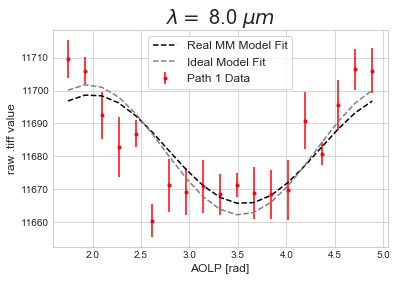

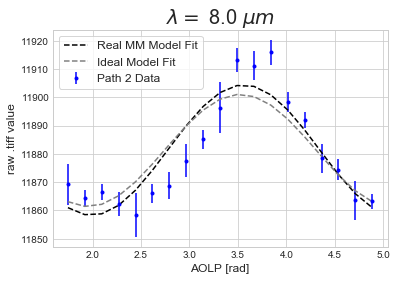

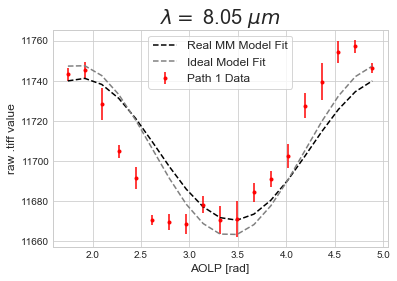

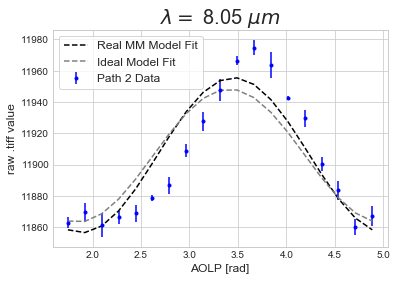

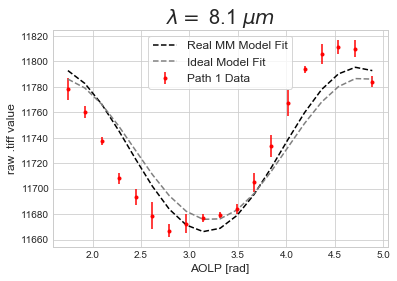

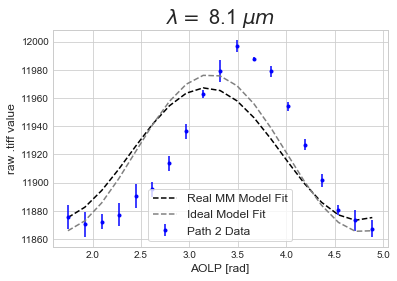

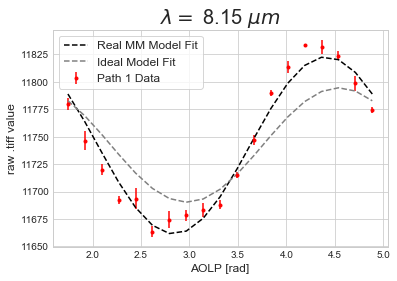

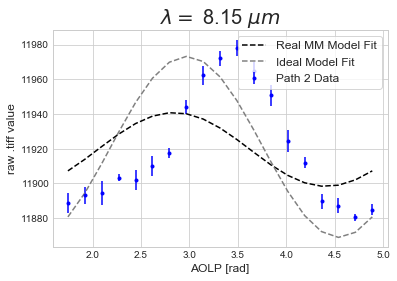

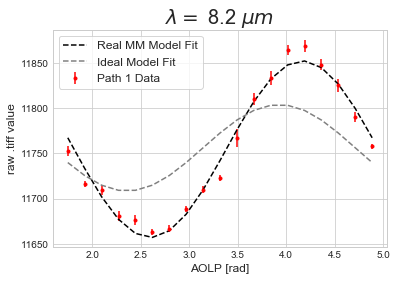

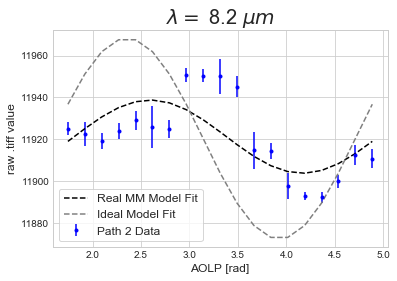

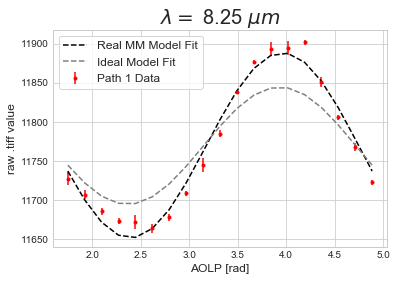

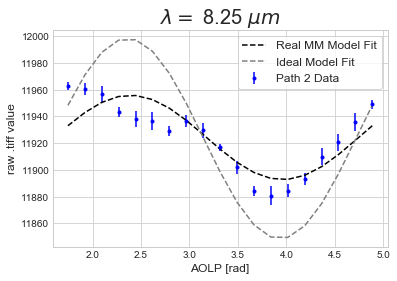

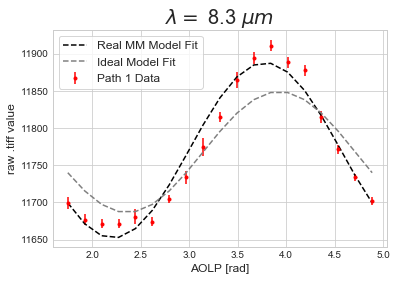

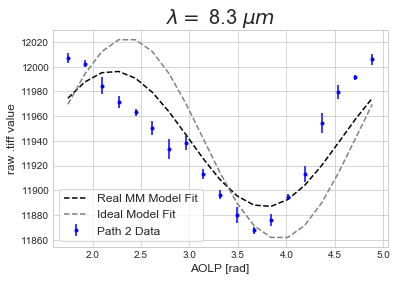

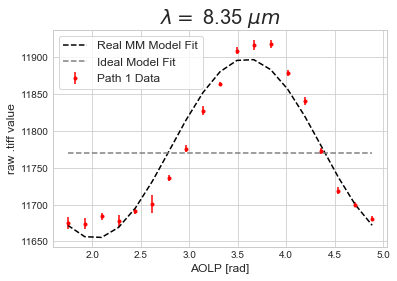

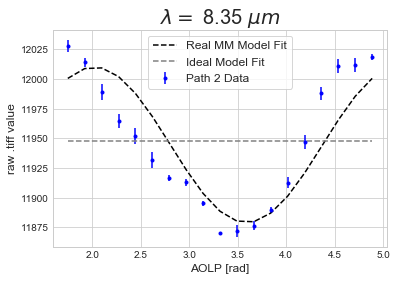

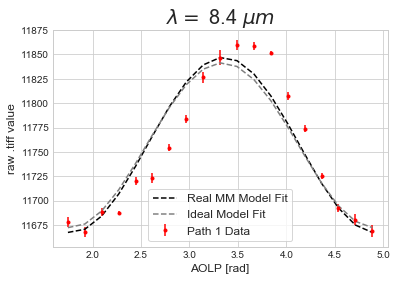

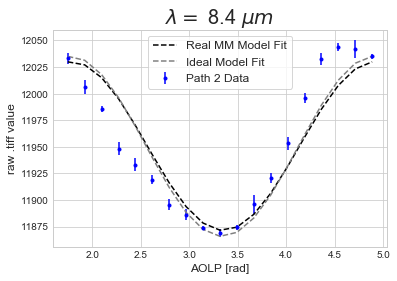

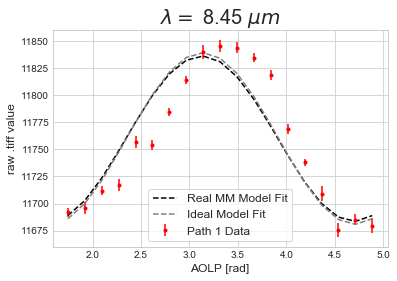

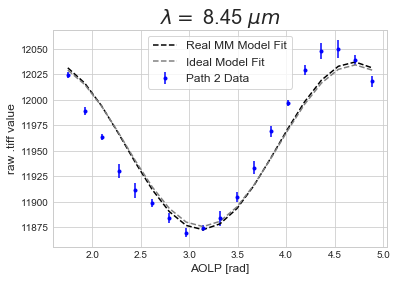

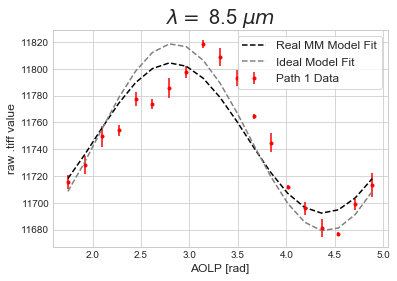

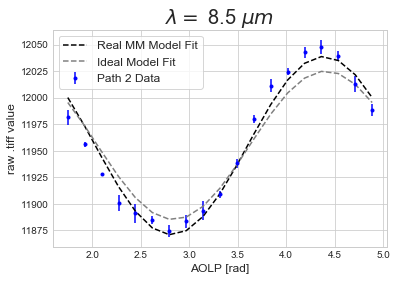

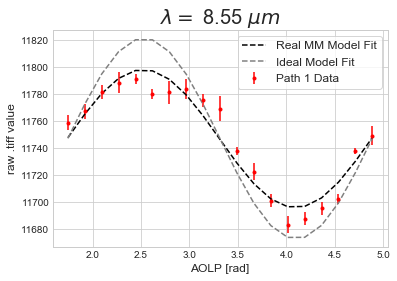

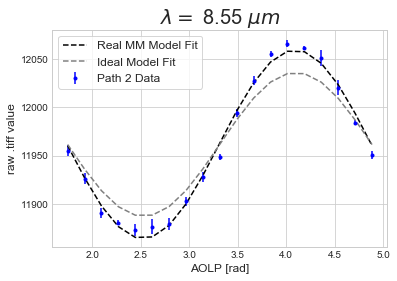

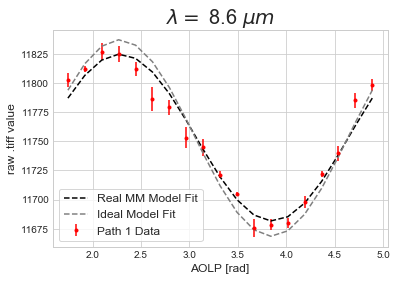

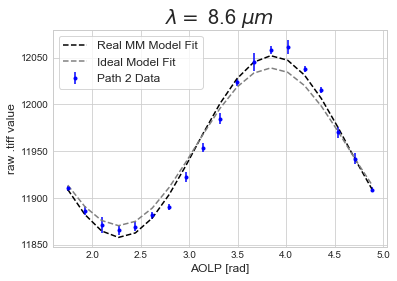

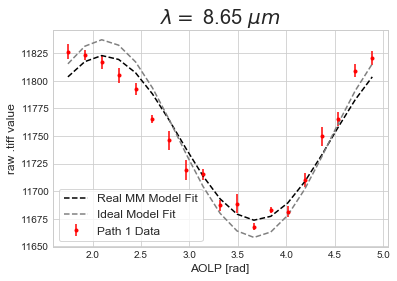

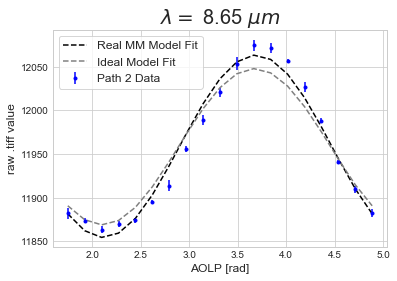

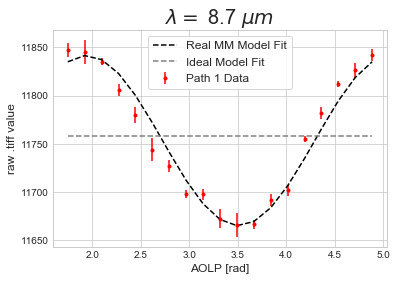

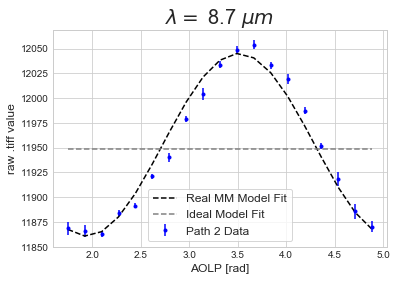

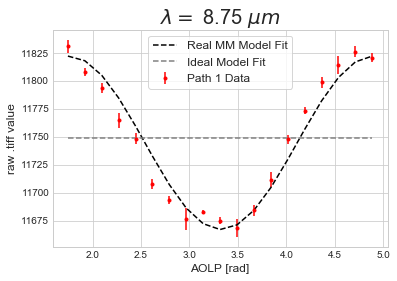

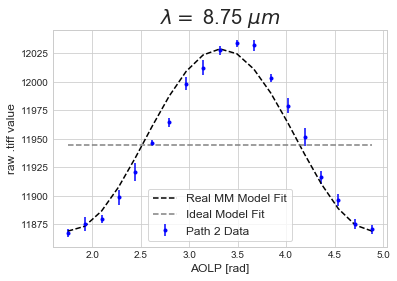

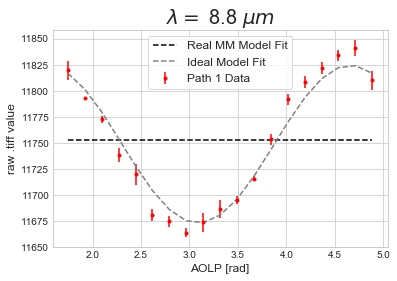

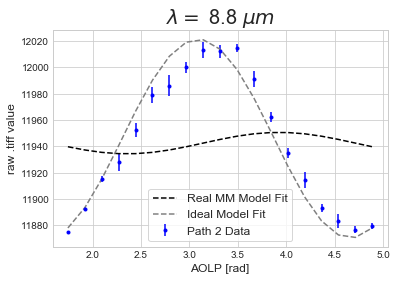

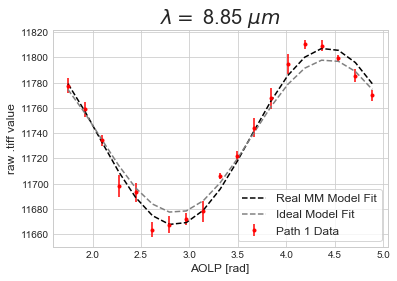

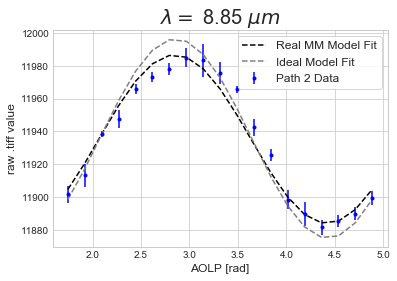

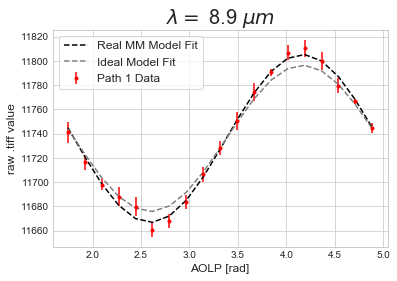

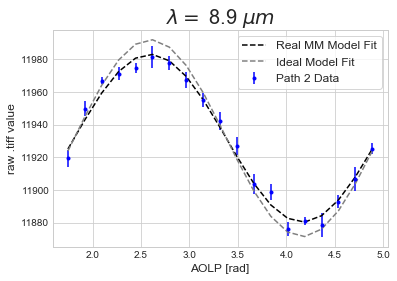

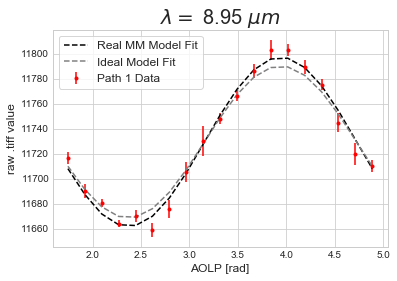

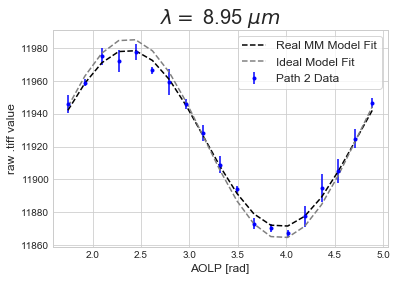

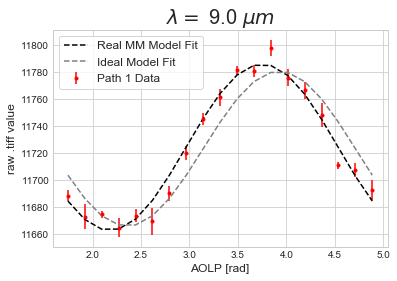

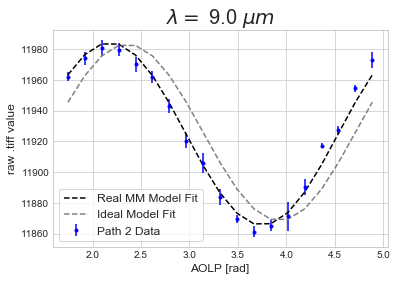

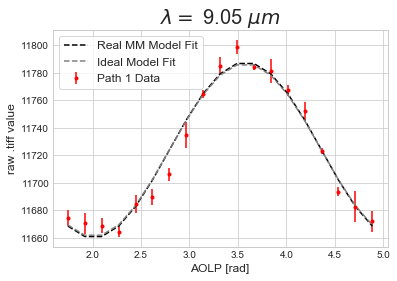

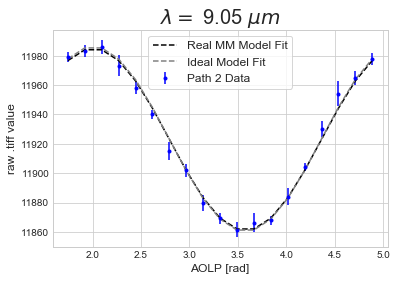

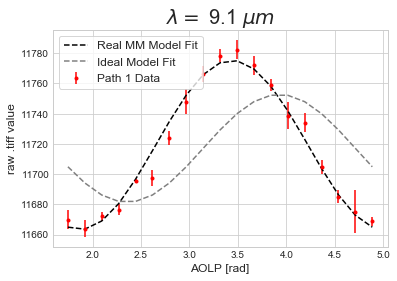

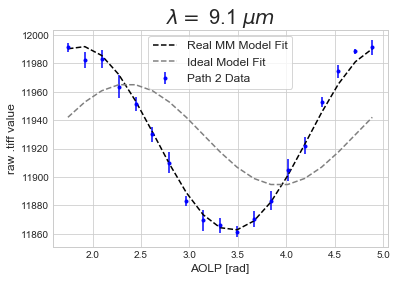

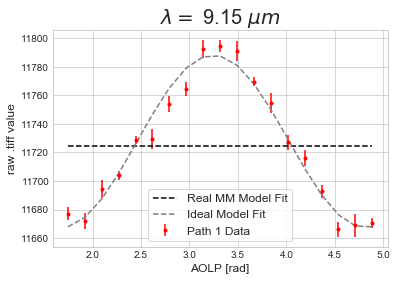

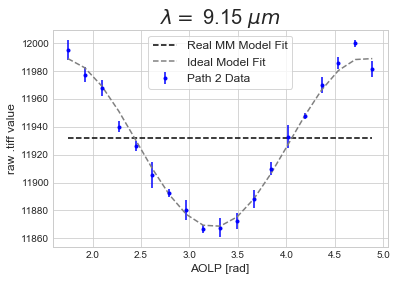

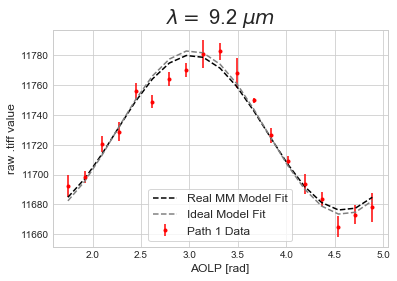

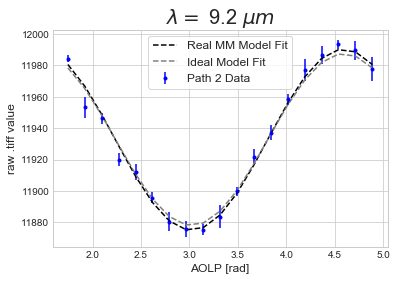

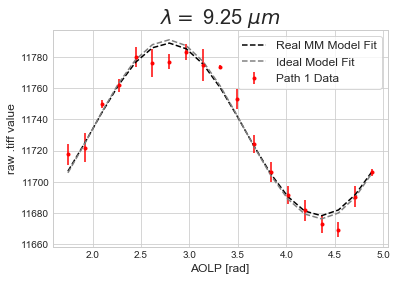

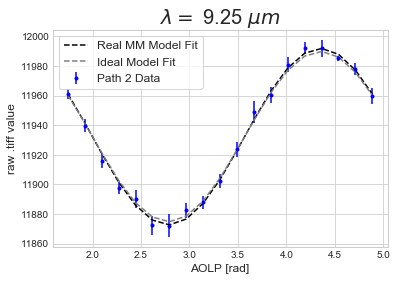

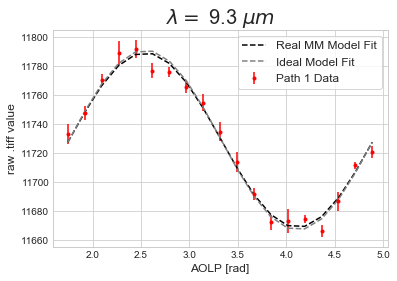

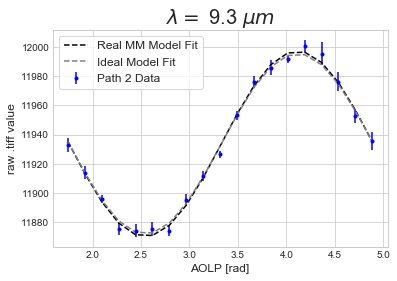

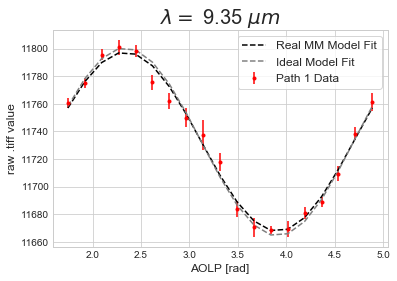

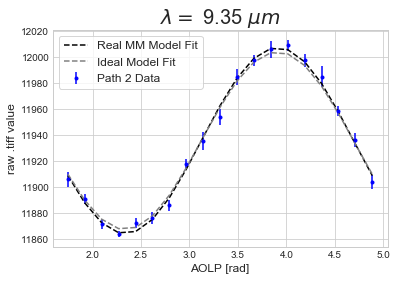

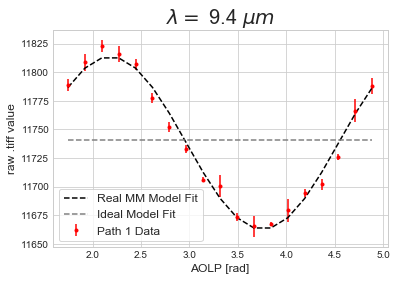

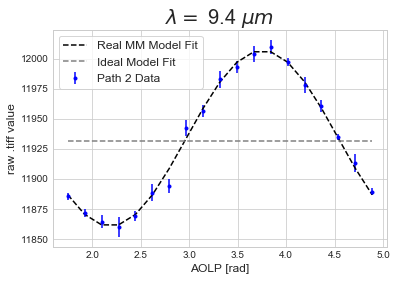

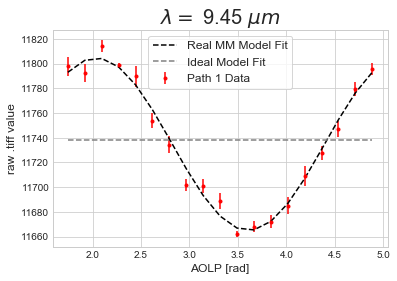

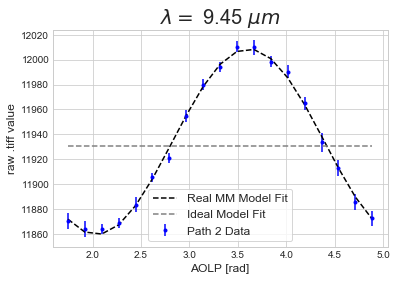

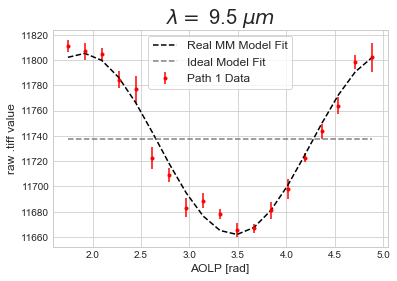

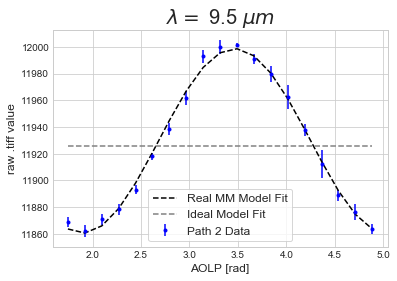

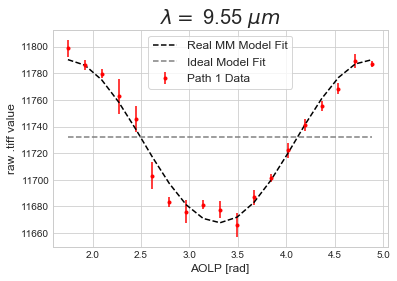

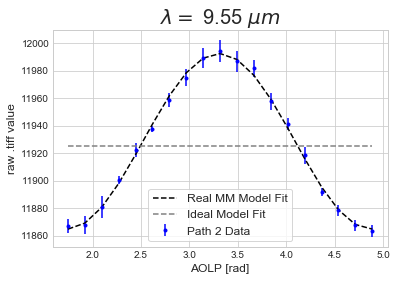

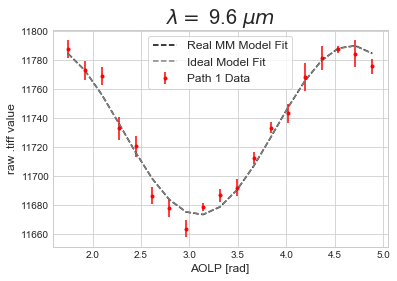

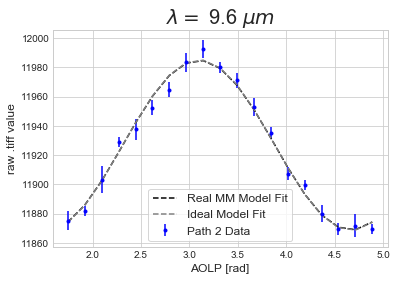

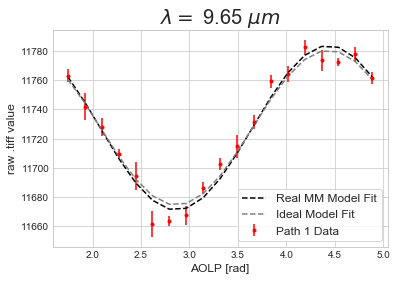

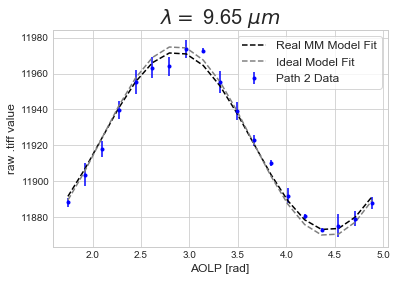

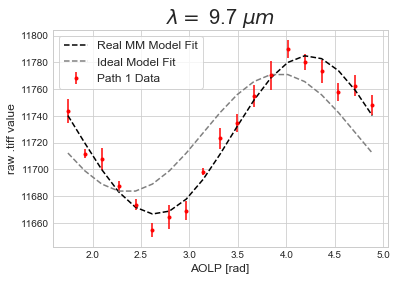

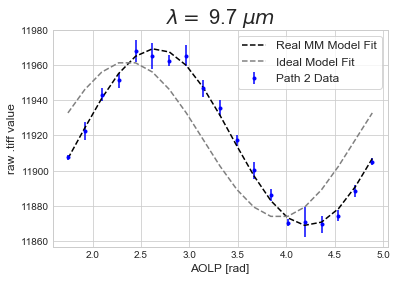

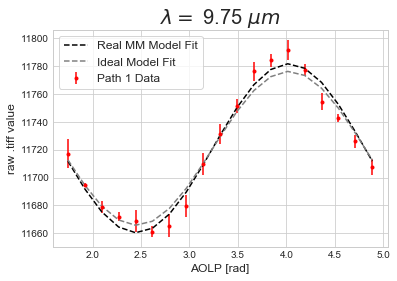

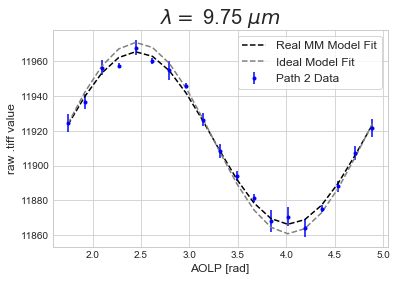

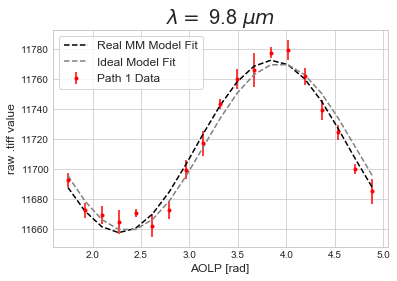

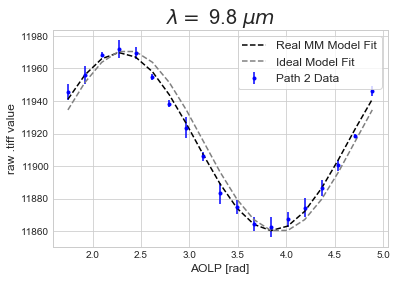

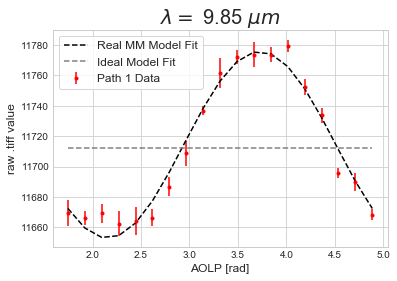

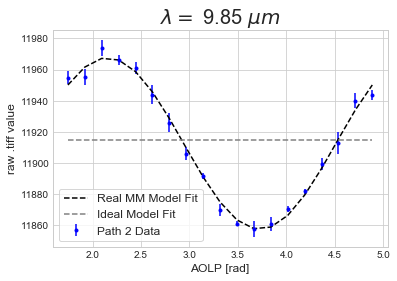

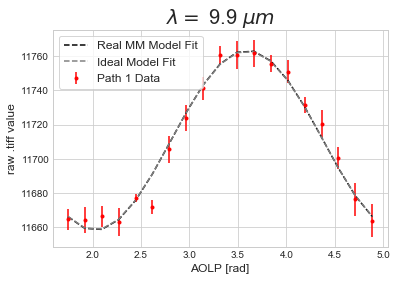

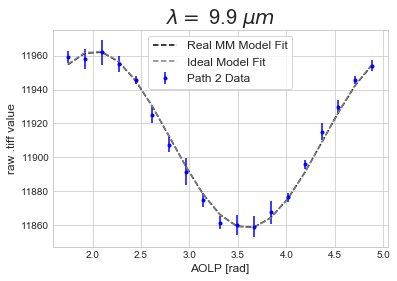

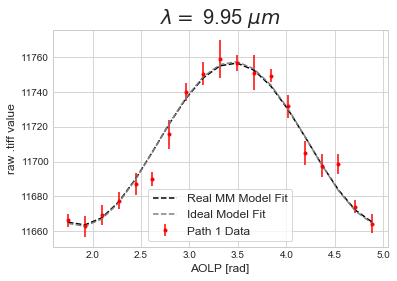

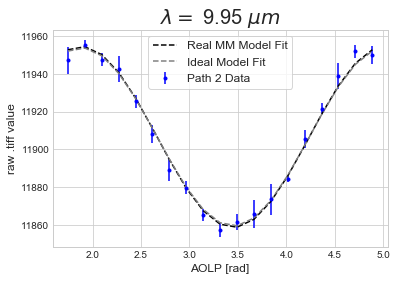

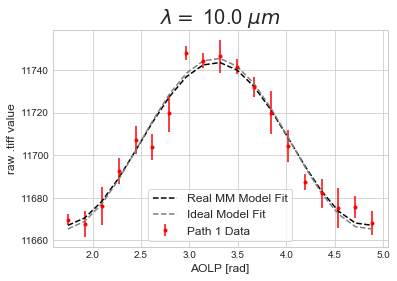

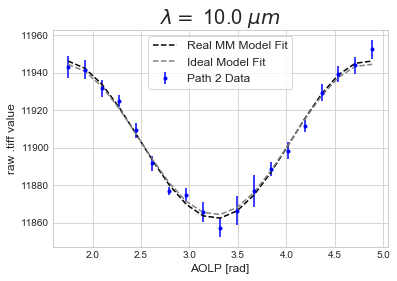

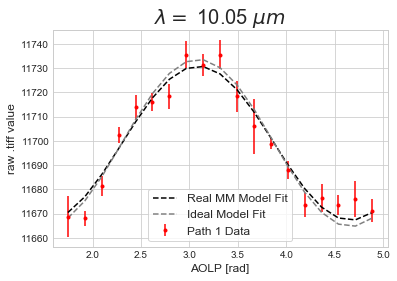

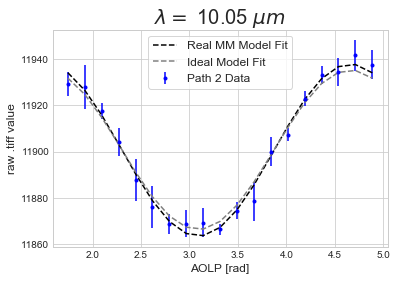

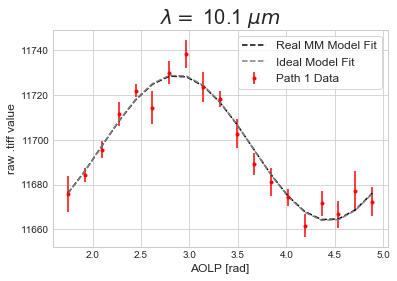

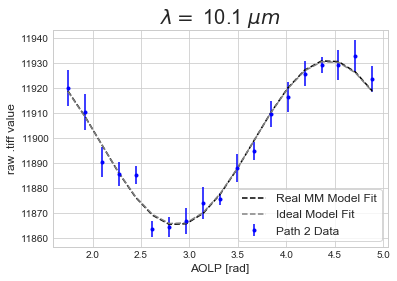

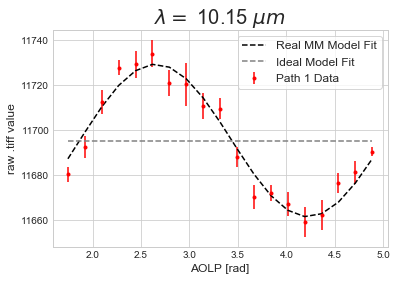

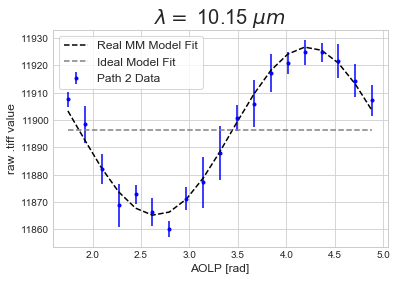

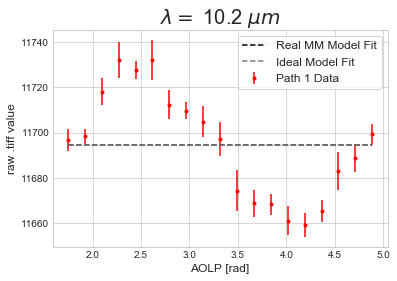

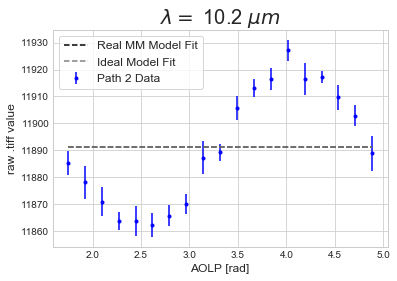

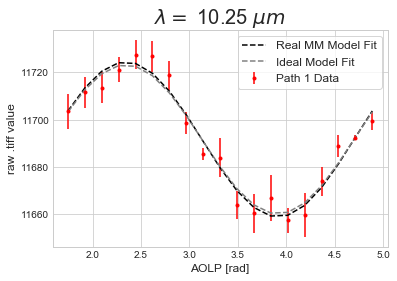

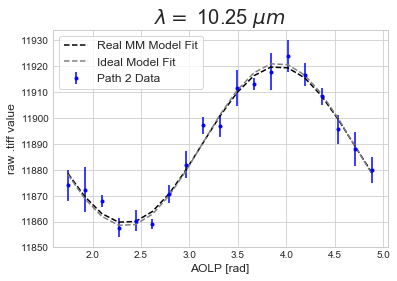

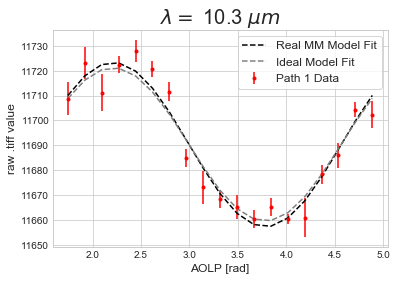

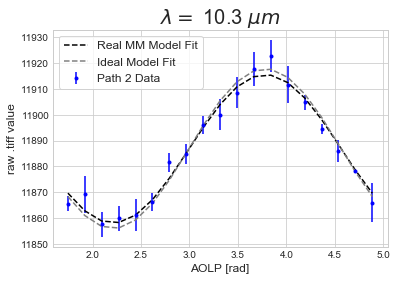

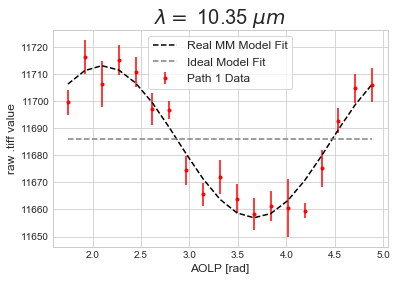

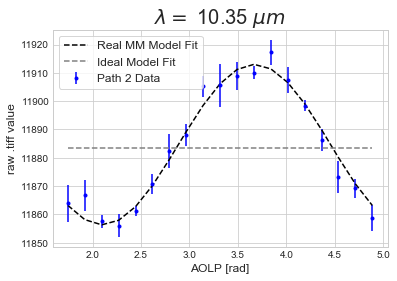

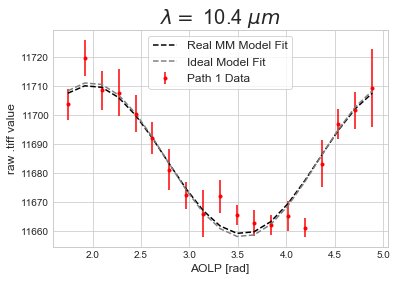

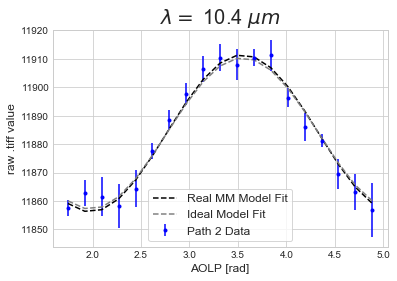

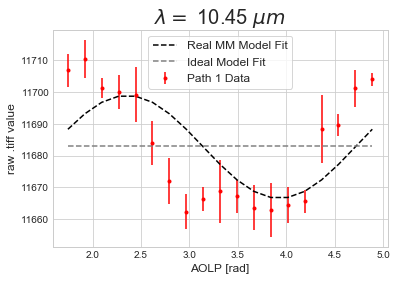

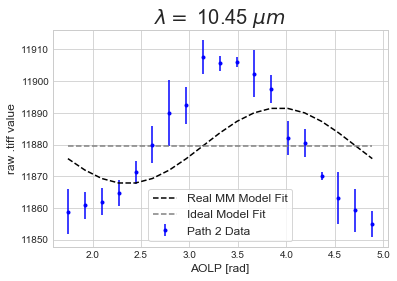

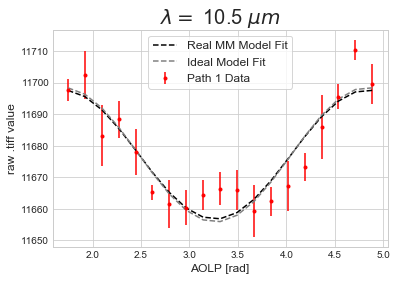

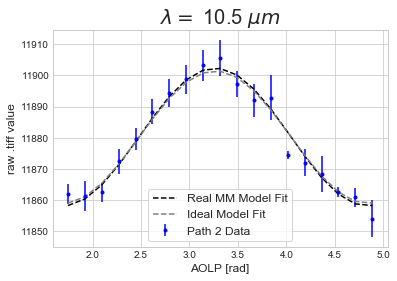

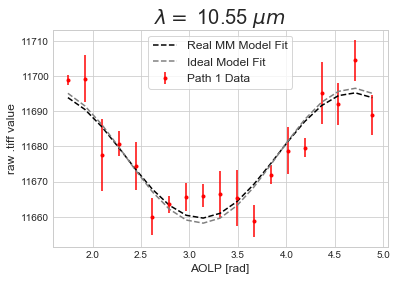

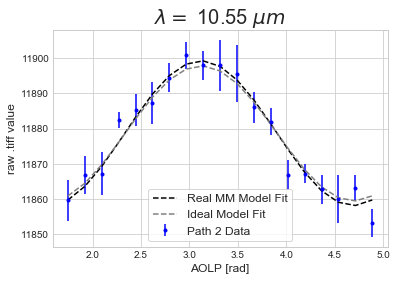

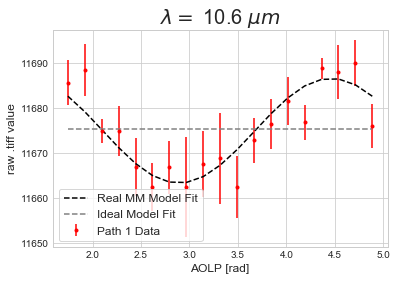

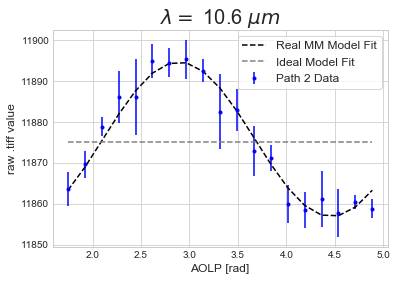

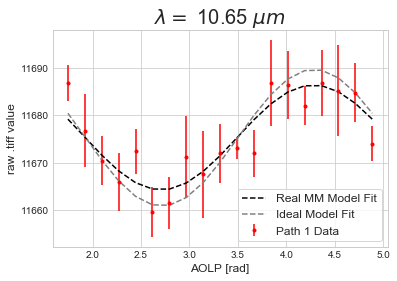

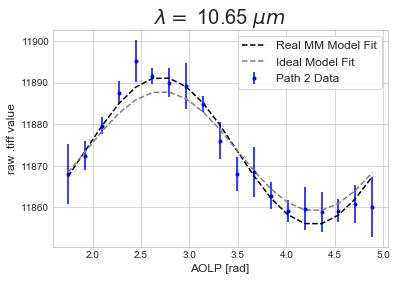

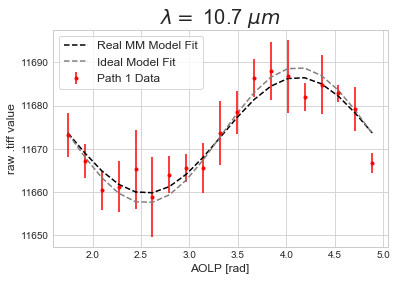

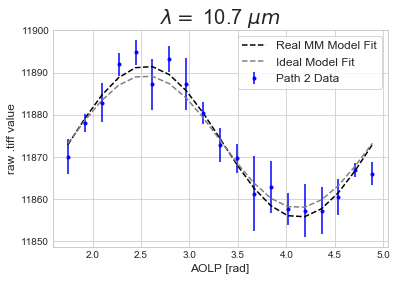

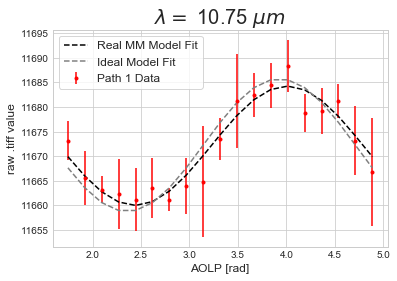

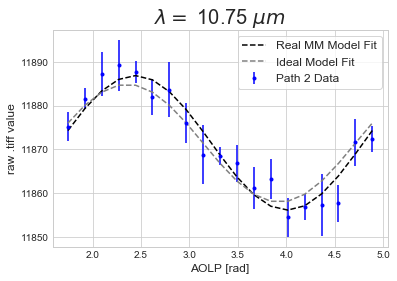

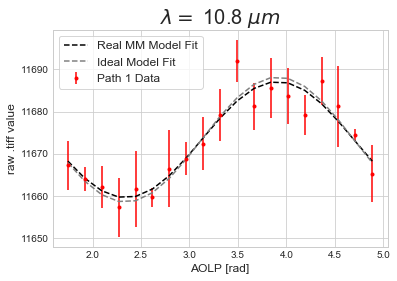

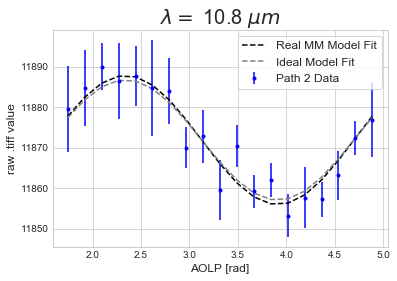

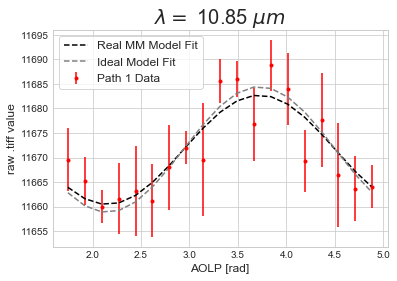

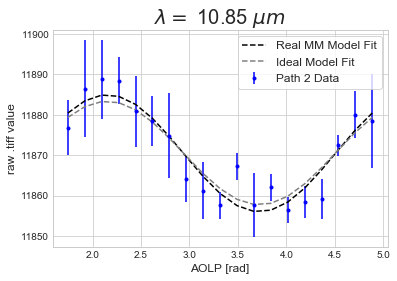

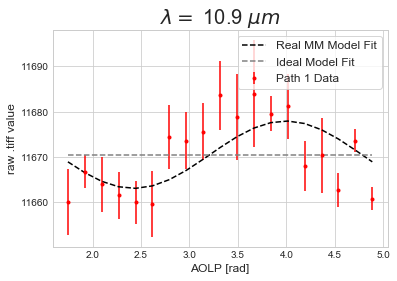

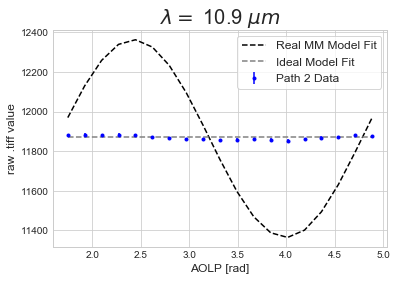

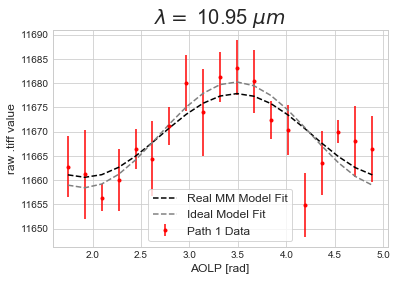

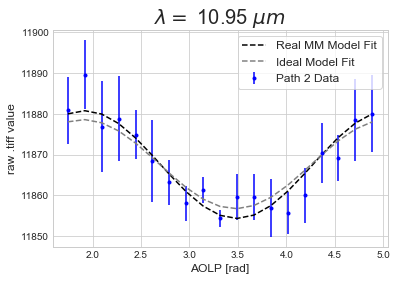

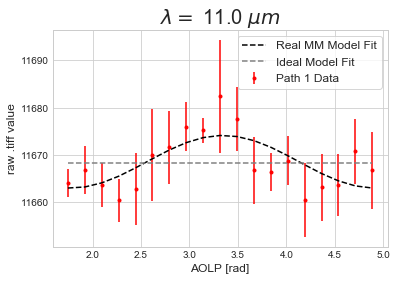

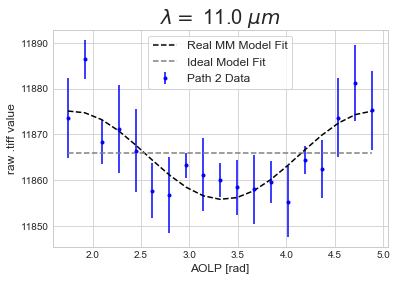

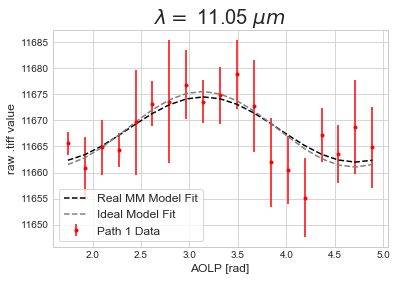

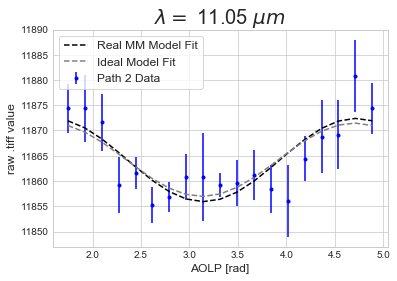

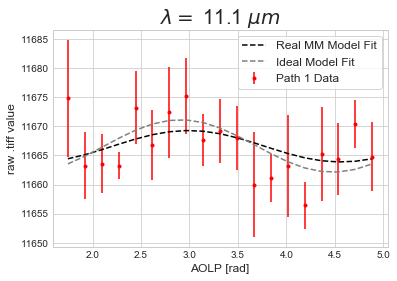

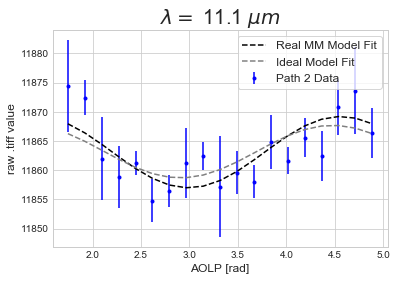

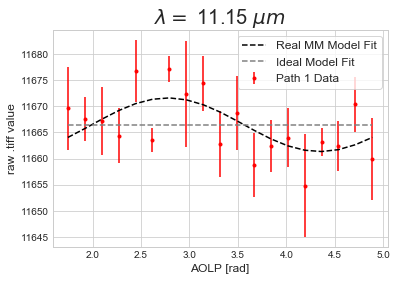

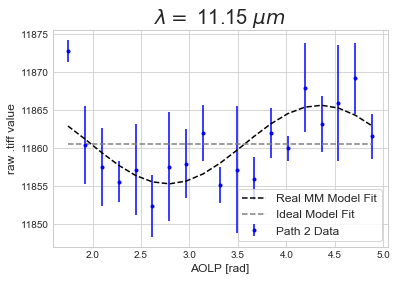

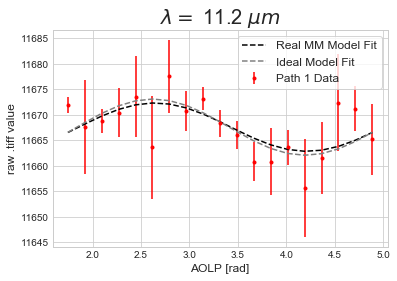

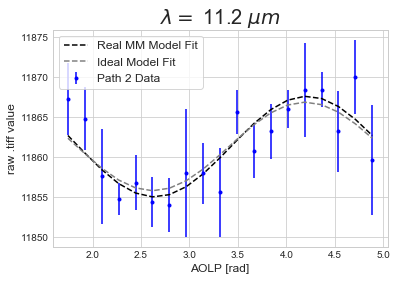

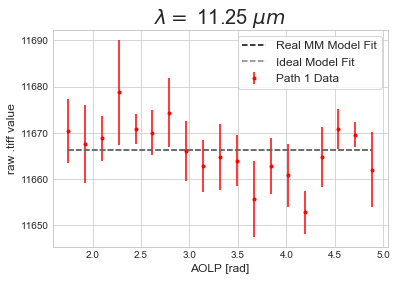

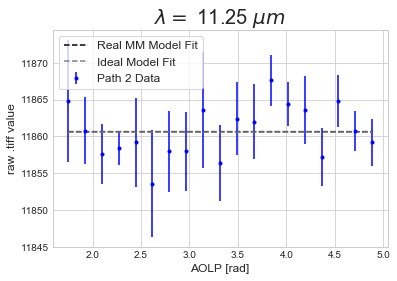

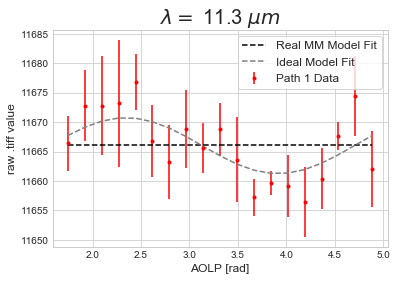

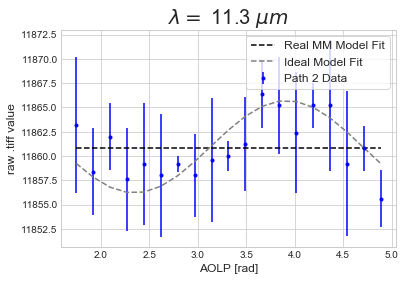

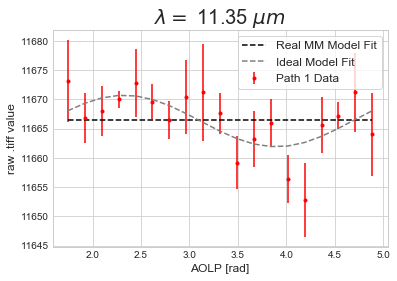

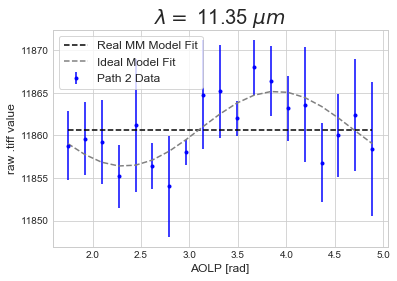

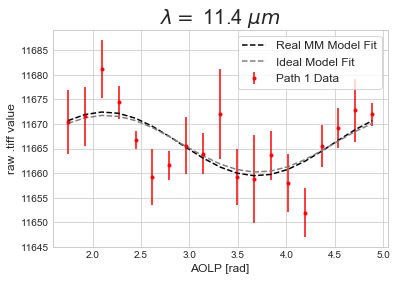

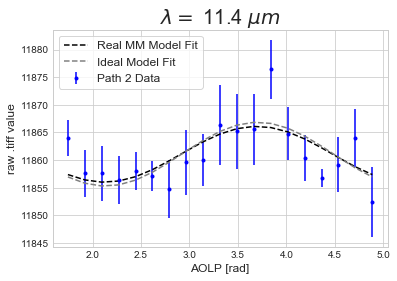

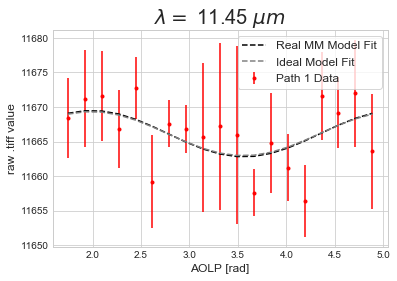

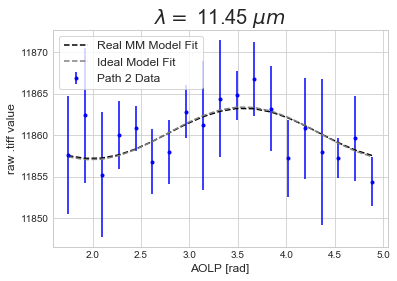

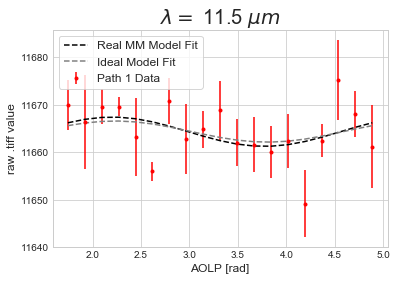

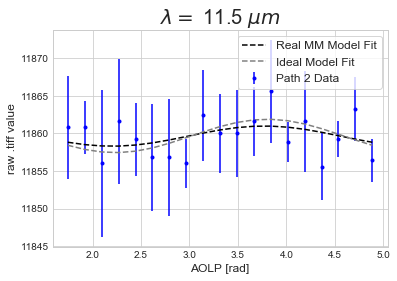

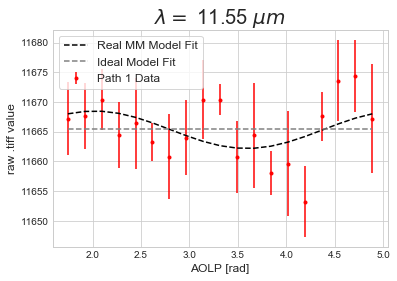

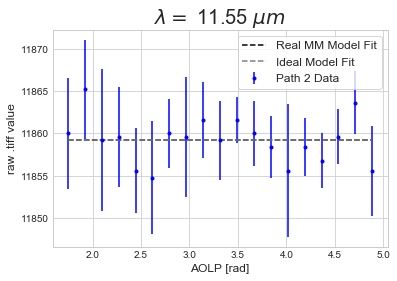

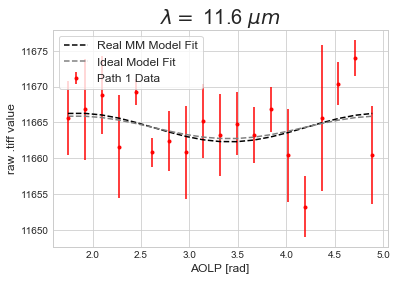

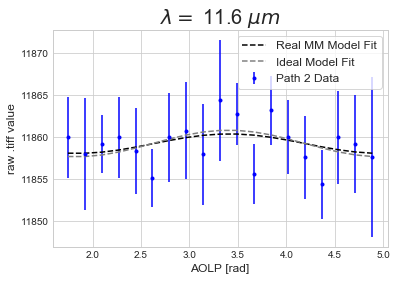

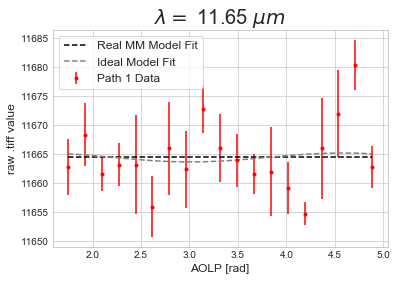

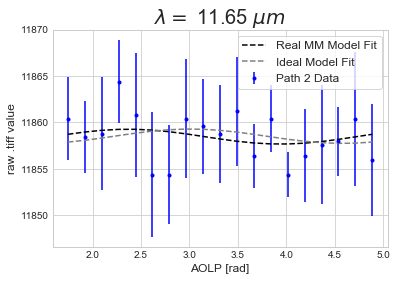

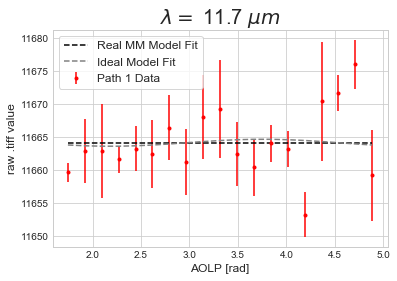

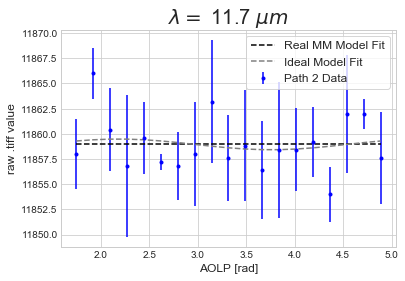

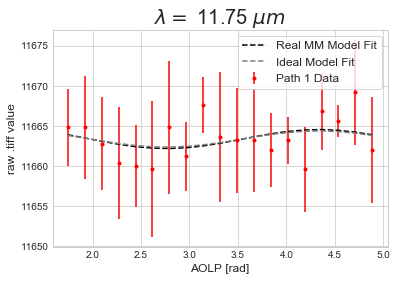

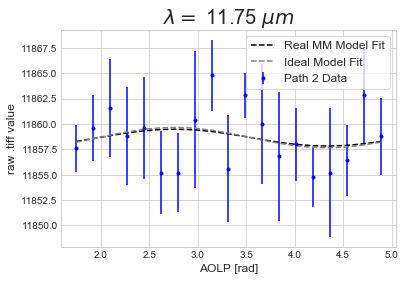

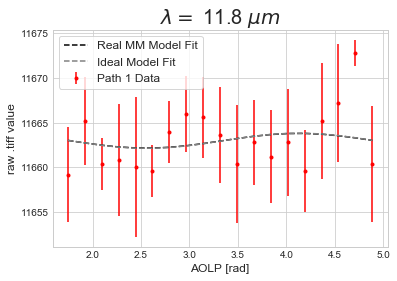

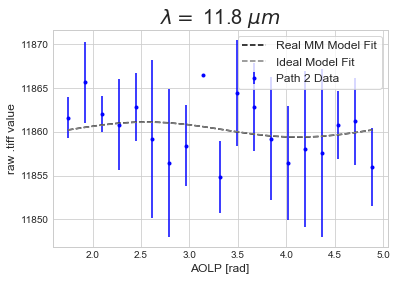

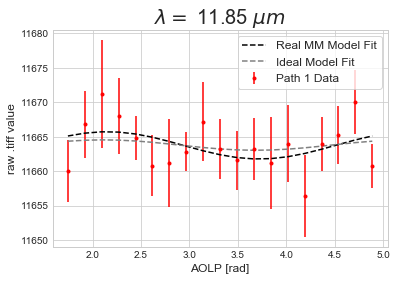

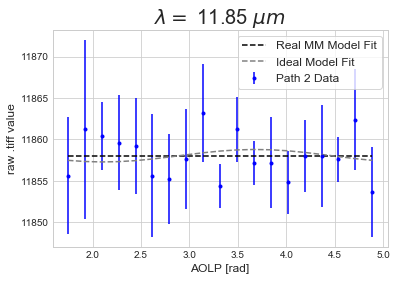

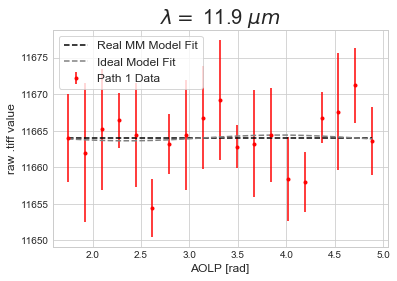

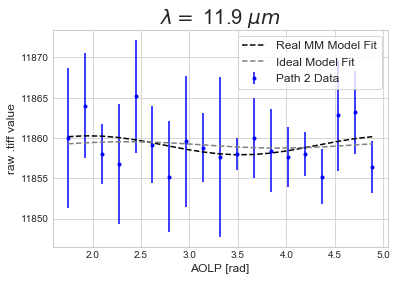

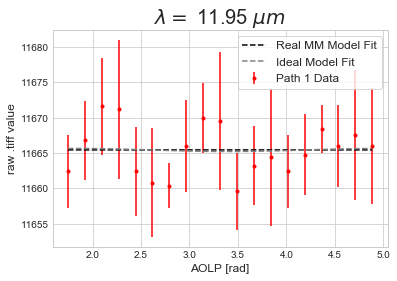

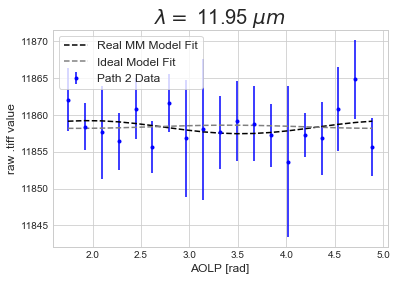

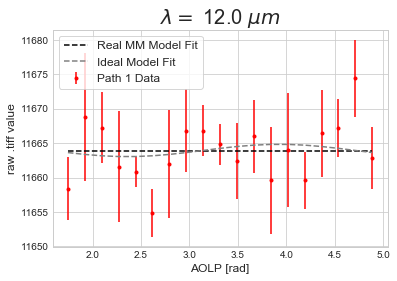

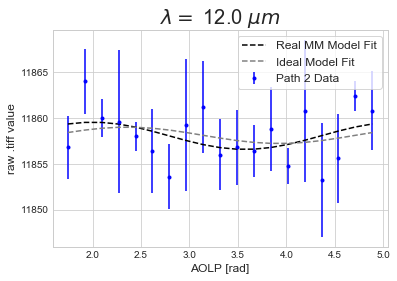

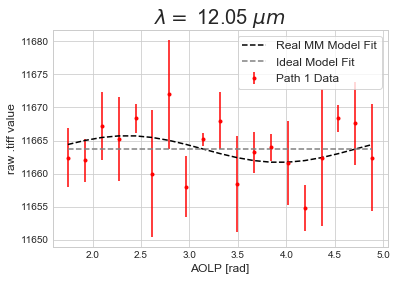

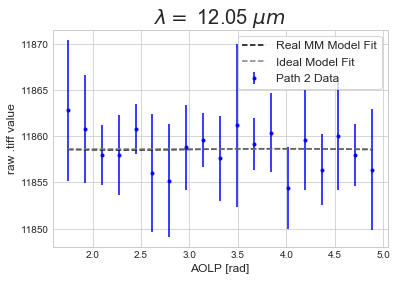

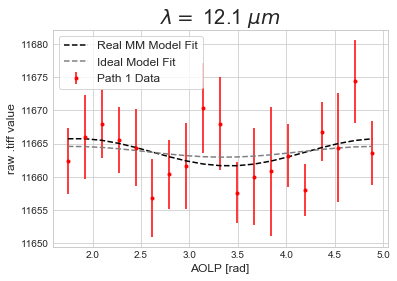

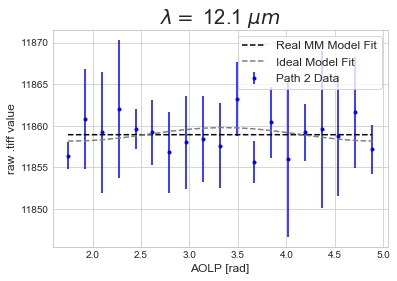

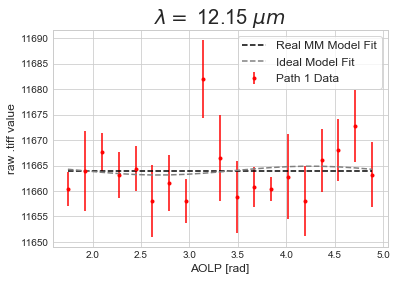

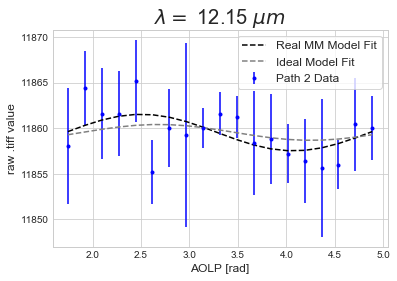

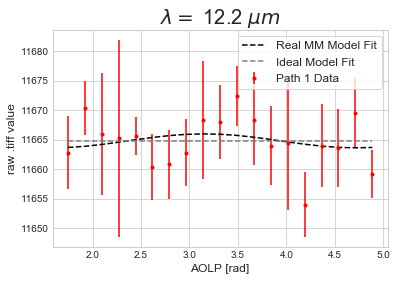

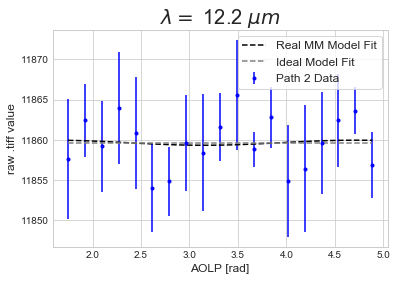

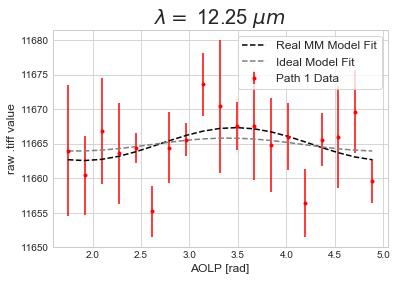

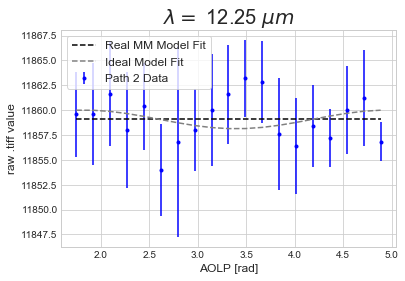

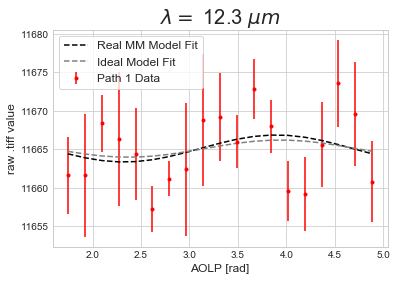

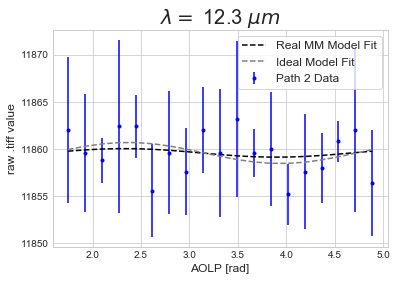

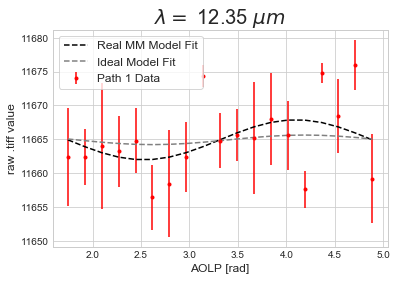

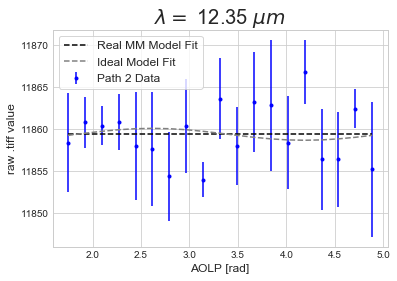

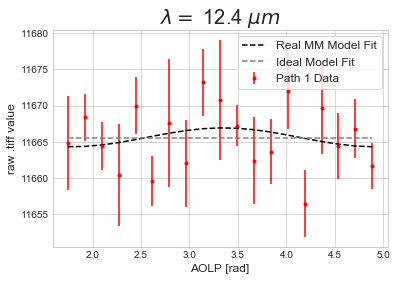

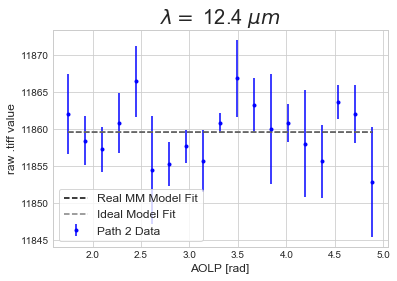

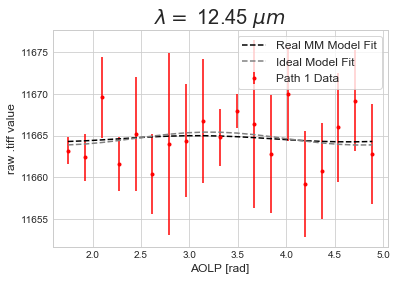

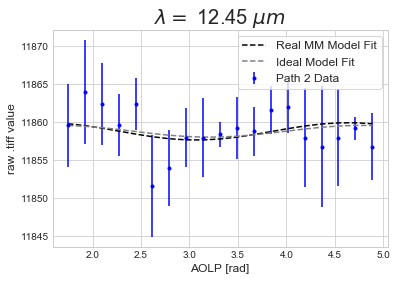

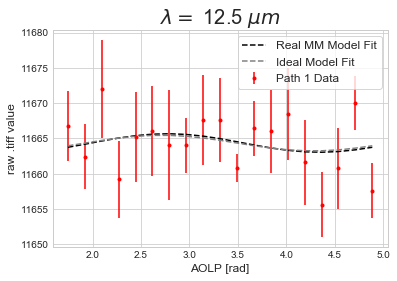

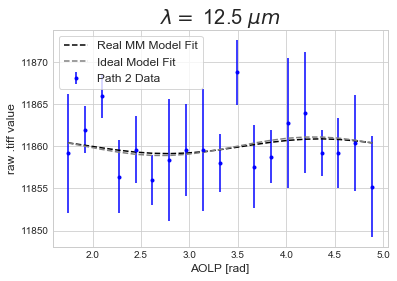

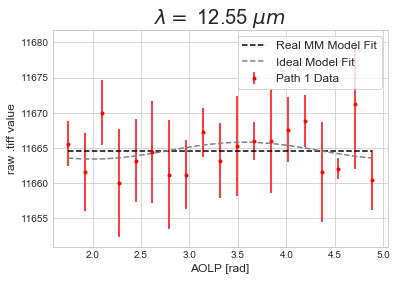

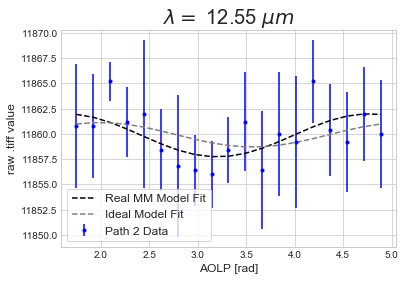

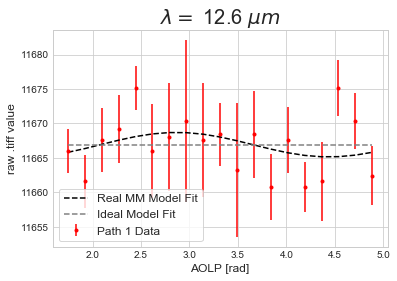

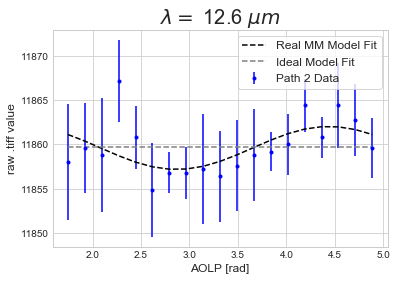

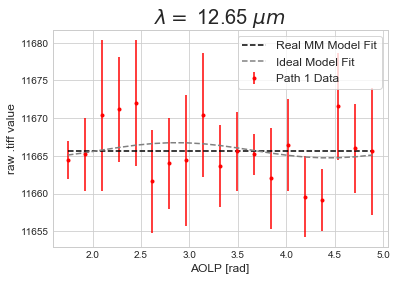

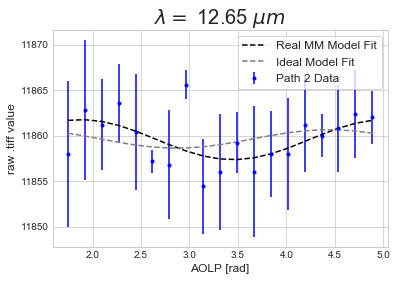

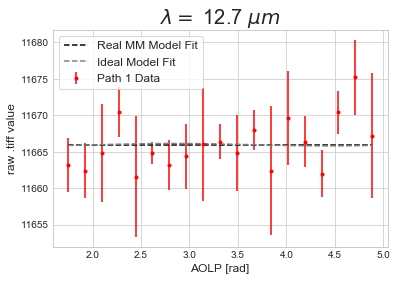

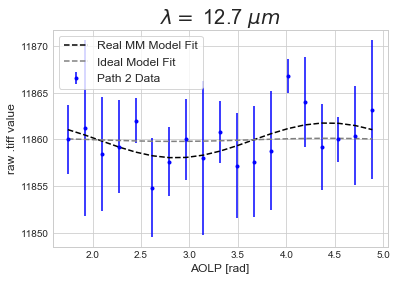

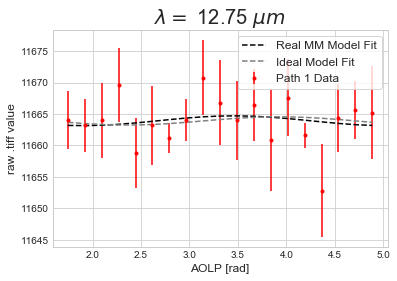

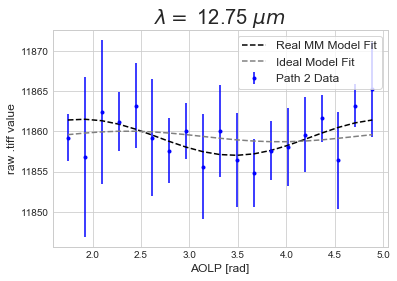

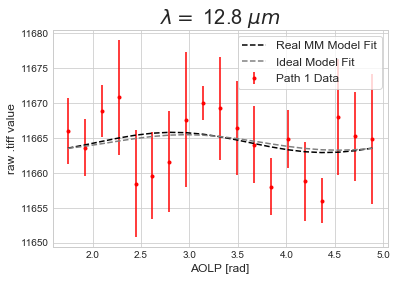

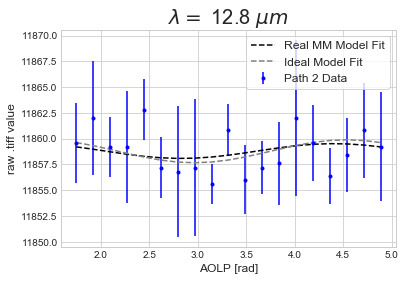

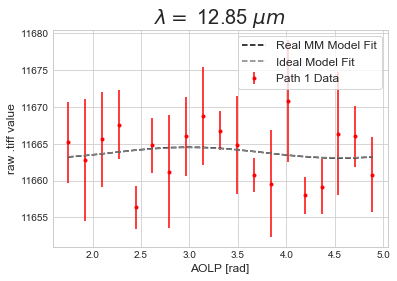

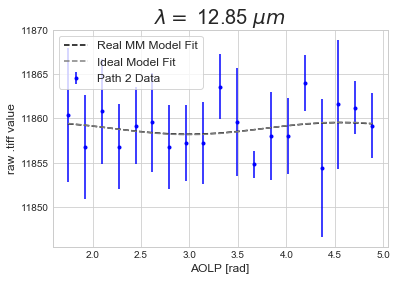

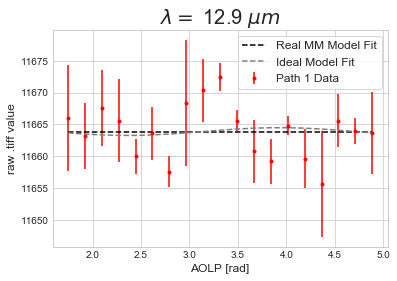

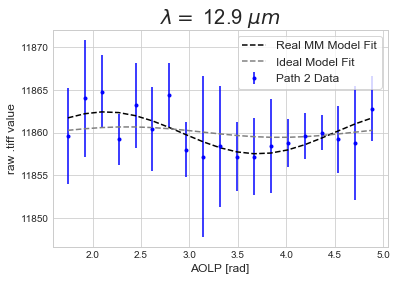

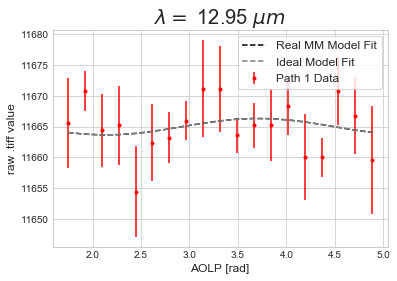

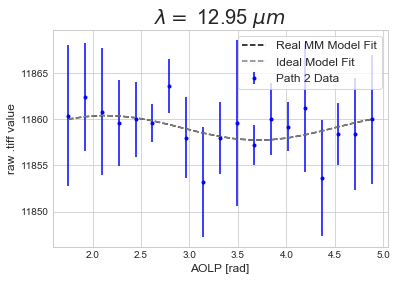

In [81]:
for i in range(0,100):
    plot_fit(i,True)
    plot_fit(i,False)
    

In [12]:
def RMSE(data,model,offset):
    r=[]
    for i in range(len(data)):
        d = data[i] 
        m = model[i] 
        r_n=(((d-m)**2.0)**0.5)/(d-offset)
        r.append(r_n)
    return(100*np.mean(r))


In [13]:
data = []
for waves_i in range(len(waves)):
    path1_data,path2_data, path1_std, path2_std,par,residual,chisqr,redchi = findfit_wavelength(waves_i,False,True)
    path1_fit,path2_fit = fit_arrays(par,theta,True)
    off1 = par['T1']; off2 = par['Rsum']
    rmse1 = np.mean(RMSE(path1_data,path1_fit,off1));rmse2 = np.mean(RMSE(path2_data,path2_fit,off2))
    data.append([path1_data,path2_data, path1_std, path2_std,par,residual,chisqr,redchi,rmse1, rmse2 ,path1_fit,path2_fit])

In [120]:
data_ideal = []
for waves_i in range(len(waves)):
    path1_data,path2_data, path1_std, path2_std,par,residual,chisqr,redchi = findfit_wavelength(waves_i,False,False)
    path1_fit,path2_fit = fit_arrays(par,theta,False)
    off1 = par['T1']; off2 = par['T1']
    rmse1 = np.mean(RMSE(path1_data,path1_fit,off1));rmse2 = np.mean(RMSE(path2_data,path2_fit,off2))
    data_ideal.append([path1_data,path2_data, path1_std, path2_std,par,residual,chisqr,redchi,rmse1, rmse2 ,path1_fit,path2_fit])

In [121]:
aolp_data = pd.DataFrame(data,
                         columns = ['path1data','path2data', 'path1_std', 'path2_std', 'par','residual','chisq','redchi',
                                    'rmse1','rmse2','path1fit','path2 fit'])

aolp_data_ideal = pd.DataFrame(data_ideal,
                         columns = ['path1data','path2data', 'path1_std', 'path2_std', 'par','residual','chisq','redchi',
                                    'rmse1','rmse2','path1fit','path2 fit'])

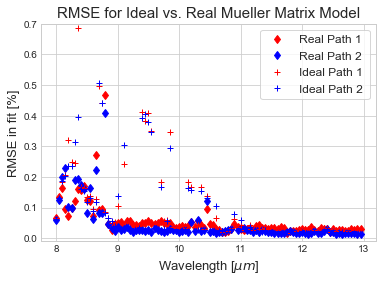

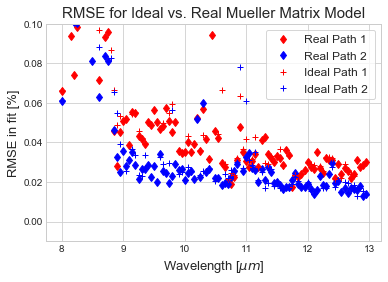

In [191]:
plt.plot(waves_um,aolp_data.rmse1,'rd')
plt.plot(waves_um,aolp_data.rmse2,'bd')
plt.plot(waves_um,aolp_data_ideal.rmse1,'r+')
plt.plot(waves_um,aolp_data_ideal.rmse2,'b+')
plt.xlabel('Wavelength [$\mu m$]',size=13)
plt.ylabel('RMSE in fit [%]',size=13)
plt.ylim(-.01,.7)
plt.title('RMSE for Ideal vs. Real Mueller Matrix Model',size = 15 )
plt.gca().legend(('Real Path 1 ','Real Path 2 ','Ideal Path 1','Ideal Path 2'),loc='best',frameon=True,fontsize=12)
plt.show()

plt.plot(waves_um,aolp_data.rmse1,'rd')
plt.plot(waves_um,aolp_data.rmse2,'bd')
plt.plot(waves_um,aolp_data_ideal.rmse1,'r+')
plt.plot(waves_um,aolp_data_ideal.rmse2,'b+')
plt.xlabel('Wavelength [$\mu m$]',size=13)
plt.ylabel('RMSE in fit [%]',size=13)
plt.ylim(-.01,.1)
plt.title('RMSE for Ideal vs. Real Mueller Matrix Model',size = 15 )
plt.gca().legend(('Real Path 1 ','Real Path 2 ','Ideal Path 1','Ideal Path 2'),loc='best',frameon=True,fontsize=12)
plt.show()

In [123]:
def get_par_slice(par,key):
    p = []
    for i in range(len(par)):
        p.append(par[i][key])
    return(p)

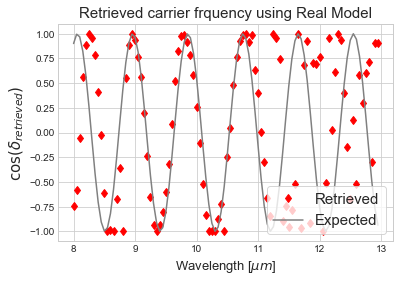

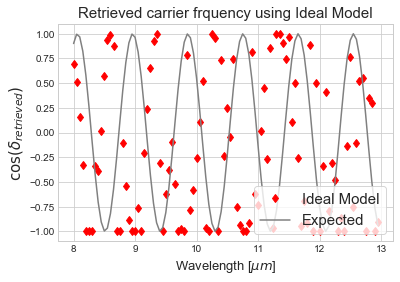

In [183]:
par = aolp_data.par
par_ideal = aolp_data_ideal.par

def ret(wave,a,b):
    freq = np.multiply(a,wave)
    phase = np.add(freq,b)
    return(np.cos(phase))

plt.plot(waves_um,np.cos(get_par_slice(par, 'delta')),'d',c = 'r',label='Retrieved')
plt.plot(waves_um,ret(waves_um,7.0,.1),'-',c = 'grey',label='Expected')
#plt.plot(waves_um,ret(waves_um,7.5,0),'-',c = 'grey',label='Expected')
plt.title('Retrieved carrier frquency using Real Model',size = 15)
plt.ylabel('$\cos(\delta_{retrieved})$',size = 15)
plt.xlabel('Wavelength [$\mu m$]',size=13)
plt.legend(frameon=True,fontsize=15,loc = 4)
plt.show()


plt.plot(waves_um,np.cos(get_par_slice(par_ideal, 'delta')),'d',c = 'r',label='Ideal Model')
plt.title('Retrieved carrier frquency using Ideal Model',size = 15)
plt.plot(waves_um,ret(waves_um,7.0,.1),'-',c = 'grey',label='Expected')
plt.ylabel('$\cos(\delta_{retrieved})$',size = 15)
plt.xlabel('Wavelength [$\mu m$]',size=13)
plt.legend(frameon=True,fontsize=15,loc = 4)
plt.show()

In [200]:
print(np.mean(aolp_data.rmse2[10:60]),np.std(aolp_data.rmse2[10:60]))

0.10147703355943713 0.37963674567815947


In [193]:
np.mean(aolp_data.rmse2)

0.07414082617801988